In [1]:
# reference: https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html

import feather
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import timeit

random = np.random.RandomState(112)
test_range = range(3, 8)

In [2]:
def test_csv_write(df):
    df.to_csv('test.csv', mode='w', index=False)
    return 'test.csv'


def test_csv_read():
    return pd.read_csv('test.csv')


def test_json_write(df):
    df.to_json('test.json')
    return 'test.json'


def test_json_read():
    return pd.read_json('test.json')


def test_excel_write(df):
    df.to_excel('test.xlsx', engine='xlsxwriter')
    return 'test.xlsx'


def test_excel_read():
    return pd.read_excel('test.xlsx')


def test_hdf_fixed_write(df):
    df.to_hdf('test_fixed.hdf', 'test', mode='w')
    return 'test_fixed.hdf'


def test_hdf_fixed_read():
    return pd.read_hdf('test_fixed.hdf', 'test')


def test_hdf_fixed_write_compress(df):
    df.to_hdf('test_fixed_compress.hdf', 'test', mode='w', complib='blosc')
    return 'test_fixed_compress.hdf'


def test_hdf_fixed_read_compress():
    return pd.read_hdf('test_fixed_compress.hdf', 'test')


def test_hdf_table_write(df):
    df.to_hdf('test_table.hdf', 'test', mode='w', format='table')
    return 'test_table.hdf'


def test_hdf_table_read():
    return pd.read_hdf('test_table.hdf', 'test')


def test_hdf_table_write_compress(df):
    df.to_hdf('test_table_compress.hdf', 'test', mode='w', complib='blosc', format='table')
    return 'test_table_compress.hdf'


def test_hdf_table_read_compress():
    return pd.read_hdf('test_table_compress.hdf', 'test')


def test_feather_write(df):
    df.to_feather('test.feather')
    return 'test.feather'


def test_feather_read():
    return feather.read_dataframe('test.feather')


def test_parquet_write(df):
    df.to_parquet('test.parquet')
    return 'test.parquet'


def test_parquet_read():
    return pd.read_parquet('test.parquet')


def test_msgpack_write(df):
    df.to_msgpack('test.msgpack')
    return 'test.msgpack'


def test_msgpack_read():
    return pd.read_msgpack('test.msgpack')


def test_pickle_write(df):
    df.to_pickle('test.pkl')
    return 'test.pkl'


def test_pickle_read():
    return pd.read_pickle('test.pkl')


def test_pickle_write_compress(df):
    df.to_pickle('test.pkl.compress', compression='xz')
    return 'test.pkl.compress'


def test_pickle_read_compress():
    return pd.read_pickle('test.pkl.compress', compression='xz')
    

read_func = [
    test_csv_read,
    test_json_read,
    test_excel_read,
    test_hdf_fixed_read,
    test_hdf_fixed_read_compress,
    test_hdf_table_read,
    test_hdf_table_read_compress,
    test_feather_read,
    test_parquet_read,
    test_msgpack_read,
    test_pickle_read,
    test_pickle_read_compress
]

write_func = [
    test_csv_write,
    test_json_write,
    test_excel_write,
    test_hdf_fixed_write,
    test_hdf_fixed_write_compress,
    test_hdf_table_write,
    test_hdf_table_write_compress,
    test_feather_write,
    test_parquet_write,
    test_msgpack_write,
    test_pickle_write,
    test_pickle_write_compress
]

filenames = [
    'test.csv',
    'test.json',
    'test.xlsx',
    'test_fixed.hdf',
    'test_fixed_compress.hdf',
    'test_table.hdf',
    'test_table_compress.hdf',
    'test.feather',
    'test.parquet',
    'test.msgpack',
    'test.pkl',
    'test.pkl.compress'
]


In [3]:
def test_io(df, loops=5):
    read_speed = dict()
    write_speed = dict()
    filesize = dict()
    
    for func in write_func:
        key = func.__name__
        write_speed[key] = 0.0
#         print('Testing function', key)
        for _ in range(loops):
            start = timeit.default_timer()
            func(df)
            end = timeit.default_timer()
            write_speed[key] += end - start
        write_speed[key] /= loops
    
    for func, filename in zip(read_func, filenames):
        key = func.__name__
        read_speed[key] = 0.0
#         print('Testing function', key)
        for _ in range(loops):
            start = timeit.default_timer()
            df_read = func()
            end = timeit.default_timer()
            read_speed[key] += end - start
        read_speed[key] /= loops
        filesize[filename] = os.path.getsize(filename)
    
    return write_speed, read_speed, filesize

def show_result(df_name, write_speed, read_speed, filesize):
    read_data = dict()
    write_data = dict()
    size_data = dict()
    
    index = []
    data = []
    for rfunc in read_func:
        read_data[rfunc.__name__] = list()
        for i in test_range:
            read_data[rfunc.__name__].append(read_speed[i][rfunc.__name__])
        index.append(rfunc.__name__)
        data.append(read_data[rfunc.__name__])
            
    for wfunc in write_func:
        write_data[wfunc.__name__] = list()
        for i in test_range:
            write_data[wfunc.__name__].append(write_speed[i][wfunc.__name__])
        index.append(wfunc.__name__)
        data.append(write_data[wfunc.__name__])
        
    for filename in filenames:
        size_data[filename] = filesize[filename] = list()
        for i in test_range:
            size_data[filename].append(filesize[i][filename] / 1e6)
        index.append(filename)
        data.append(size_data[filename])
    
    df = pd.DataFrame(index=index, data=data, columns=['10^%d' % i for i in test_range])
    df.index.name = 'function'
    df.to_csv('data/%s.csv' % df_name.replace(' ', ''))

    
    plt.clf()
    fig, ax = plt.subplots(3, 1, figsize=(7, 14))
    plt.sca(ax[0])

    for rfunc in read_func:
        d = read_data[rfunc.__name__]
        plt.semilogy(np.arange(len(d)), d, marker="o", label=rfunc.__name__)
    plt.title('Read Speed (%s)' % df_name, fontsize=15)
    plt.ylabel('Seconds', fontsize=13)
    plt.xticks(np.arange(len(list(test_range))), ["$10^{}$".format(x) for x in test_range])
    plt.legend(frameon=True)
    
    plt.sca(ax[1])
    for wfunc in write_func:
        d = write_data[wfunc.__name__]
        plt.semilogy(np.arange(len(d)), d, marker="o", label=wfunc.__name__)
    plt.title('Write Speed (%s)' % df_name, fontsize=15)
    plt.ylabel('Seconds', fontsize=13)
    plt.xticks(np.arange(len(list(test_range))), ["$10^{}$".format(x) for x in test_range])
    plt.legend(frameon=True)
    
    plt.sca(ax[2])
    for filename in filenames:
        d = size_data[filename]
        plt.semilogy(np.arange(len(d)), d, marker="o", label=filename)
    plt.title('File Size (%s)' % df_name, fontsize=15)
    plt.ylabel('MB', fontsize=13)
    plt.xticks(np.arange(len(list(test_range))), ["$10^{}$".format(x) for x in test_range])
    plt.legend(frameon=True)
    
    plt.savefig('images/%s.png' % df_name.replace(' ', ''), bbox_inches="tight")
    plt.show()
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
a    1000 non-null float64
b    1000 non-null float64
c    1000 non-null float64
d    1000 non-null float64
dtypes: float64(4)
memory usage: 31.3 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
a    10000 non-null float64
b    10000 non-null float64
c    10000 non-null float64
d    10000 non-null float64
dtypes: float64(4)
memory usage: 312.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
a    100000 non-null float64
b    100000 non-null float64
c    100000 non-null float64
d    100000 non-null float64
dtypes: float64(4)
memory usage: 3.1 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
a    1000000 non-null float64
b    1000000 non-null float64
c    1000000 non-null float64
d   

<Figure size 432x288 with 0 Axes>

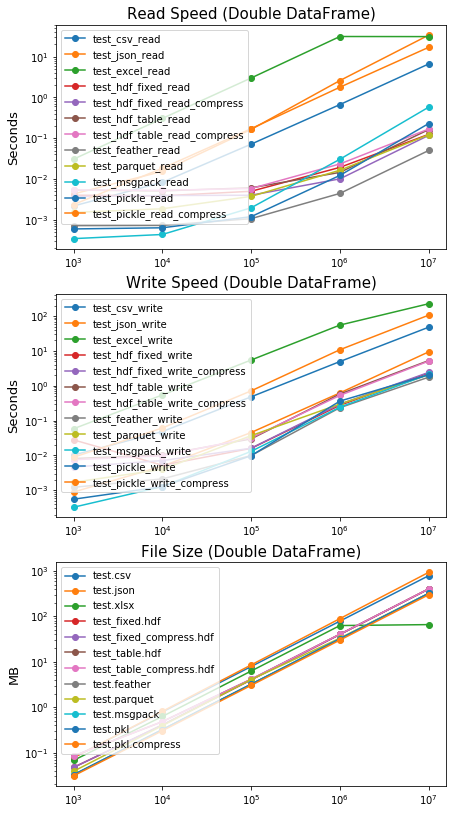

In [4]:
write_speed, read_speed, filesize = dict(), dict(), dict()
for i in test_range:
    df = pd.DataFrame(dict((x, random.randn(10 ** i)) for x in ('a', 'b', 'c', 'd')))
    print(df.info())
    write_speed_i, read_speed_i, filesize_i = test_io(df)
    write_speed[i] = write_speed_i
    read_speed[i] = read_speed_i
    filesize[i] = filesize_i
show_result('Double DataFrame', write_speed, read_speed, filesize)

In [5]:
for filename in filenames:
    os.remove(filename)